In [1]:
# Imports
import json, re, numpy as np, numpy.linalg as nplin, matplotlib.pyplot as plt, matplotlib.mlab as mlab 
import string, base64, os, hashlib, bisect as bi, time
from __future__ import division
from io import BytesIO
from pydub import AudioSegment
from operator import itemgetter
from scipy.ndimage.filters import maximum_filter
%matplotlib inline

# Am I working on AWS?
AWS = True

In [2]:
# Load Data
if AWS == True:
    songsFile = "s3n://stat-37601/new-songs.mp3.base64.json"
else:
    songsFile = "data/new-songs.mp3.base64.json"

snipets = sc.textFile(songsFile, minPartitions = 100).map(json.loads)
snipets.count()

5627

In [3]:
# Grab a subset for a short song
snipets43 = snipets.filter(lambda x: int(x["song_id"]) == 43)
print "song 43 has %d snipets" % (snipets43.count())
snipets3 = snipets.filter(lambda x: int(x["song_id"]) == 3)
print "song 3 has %d snipets" % (snipets3.count())

song 43 has 5 snipets
song 3 has 35 snipets


#### (a) process songs

In [4]:
# Helper functions, largely assembled from code given by homework/TA

def to_pydub(data):
    return AudioSegment.from_mp3(BytesIO(base64.b64decode(data)))

def audio_segment_to_samples(data):
    """Converts wav into a numpy array"""
    audio = to_pydub(data)
    wave = audio.export('_', format='wav')
    wave.seek(0)
    return np.frombuffer(wave.read(), np.int16)[24:] / 2.**15

def audio_segment_in_ipython(song_data):
    """Plays a wav file in python"""
    from IPython.core.display import HTML, display
    display(HTML("""<audio controls="controls" style="width:600px" >
        <source controls
            src="data:audio/mp3;base64,{}" type="audio/mp3" />
      </audio>""".format(song_data)))
    
def find_peaks(samples):
    """Finds peaks in sound file that are at least 20 units away from each other and greater than -150 db"""
    ft_graph = mlab.specgram(samples, scale_by_freq=False)[0]
    # Don’t rescale by 1/f!
    maxes = (maximum_filter(ft_graph, size=20) == ft_graph) & (ft_graph > -150)
    # Compute relative maxima 20 units away from others, where
    # intensity is greater than -150 dB.
    freqs, times = np.where(maxes)
    return sorted(zip(list(times),list(freqs)))

def play_pydub(pyaudio):
    """Plays a pydub audio segment in ipython"""
    pyaudio.export('tmp.mp3', format='mp3')
    audio_segment_in_ipython(base64.b64encode(open("tmp.mp3").read()))
    os.remove('tmp.mp3')

def assemble_songs(rdd):
    """
    Takes snippets of songs in an rdd and assembles them back into one whole piece.
    
    There will be noticable loss from being converted back and forth into mp3
    """
    output = rdd.map(lambda songDict: (songDict['song_id'],(songDict['time_offset'],to_py_audio(songDict['data']))))\
        .groupByKey()\
        .map(lambda (id,audio_tuples): (id, [audio for time_offset,audio in sorted(audio_tuples)]))\
        .map(lambda (id,audio_list)  : (id, reduce(lambda x,y: x+y, audio_list)))
    return output

In [5]:
# Process song into "fingerprint" of peaks - gives arrays of peak times and frequencies
# There seem to be some with way too many peaks, so I'm going to filter them out (I can't get the code to run with them anyway)
snipets_fp  = snipets.map(lambda songDict: (songDict['song_id'],songDict['time_offset'],find_peaks(audio_segment_to_samples(songDict['data']))))\
    .filter(lambda x: len(x[2])<2000)
snipets43_fp = snipets43.map(lambda songDict: (songDict['song_id'],songDict['time_offset'],find_peaks(audio_segment_to_samples(songDict['data']))))\
    .filter(lambda x: len(x[2])<2000)
snipets3_fp = snipets3.map(lambda songDict: (songDict['song_id'],songDict['time_offset'],find_peaks(audio_segment_to_samples(songDict['data']))))\
    .filter(lambda x: len(x[2])<2000)

Count the number of peaks per song.

In [6]:
# Calculate number of peaks by song
songs_peaks = snipets_fp.map(lambda (sid,off,peaks): (sid,len(peaks)))\
    .reduceByKey(lambda x,y: x+y)\
    .collect()

On average, there are 22050.77 peaks per song.


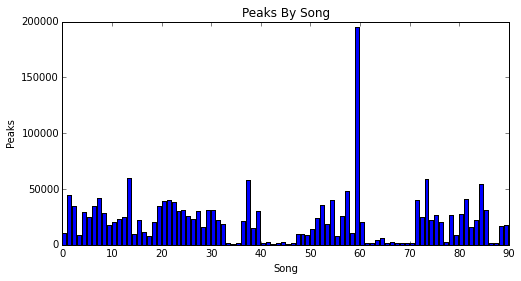

In [97]:
# summarize
song_ids, freqs = zip(*songs_peaks)    
    
print "On average, there are %.2f peaks per song." % np.mean(freqs)

plt.bar(song_ids,freqs)
plt.title("Peaks By Song")
plt.xlabel('Song')
plt.ylabel('Peaks')
plt.rcParams["figure.figsize"]= [4,8]
plt.show()

#### (b) Hashing

In [38]:
def hash_two_close_peaks((time1, freq1), (time2, freq2),reduction=0):
    """Returns a hash for two peaks"""
    return hashlib.sha1("{}:{}:{}".format(time2 - time1, freq2, freq1)).hexdigest()[:(40-reduction)]

def return_pair_hashes(peaks,radius=200,reduction=0):
    """Generates a set of hashes, each corresponding to a pair of two peaks in a segment"""
    pairs = []
    times = [time for time,freq in peaks]
    length = len(times)
    right = 0
    for i in range(length):
        right = bi.bisect_left(times,times[i]+radius,lo=max(right,i+1))
        pairs += set(map(lambda peakj: hash_two_close_peaks(peaks[i],peakj,reduction=reduction),peaks[i+1:right]))
    return pairs

def list_to_array(lst, length):
    array = np.zeros(length)
    array[lst]+= 1
    return array

Let's take a look at how quickly we lose information once we start reducing the hash

In [35]:
# count unique hashes on one short song
for red in range(0,30,5)+range(30,40,1):
    count = snipets43_fp.map(lambda (sid, off, peaks): (sid,return_pair_hashes(peaks,reduction=red)))\
        .flatMapValues(lambda x: x)\
        .distinct()\
        .count()
    print 'Reduction of %d leaves %d unique hashes' % (red,count)

Reduction of 0 leaves 22729 unique hashes
Reduction of 5 leaves 22729 unique hashes
Reduction of 10 leaves 22729 unique hashes
Reduction of 15 leaves 22729 unique hashes
Reduction of 20 leaves 22729 unique hashes
Reduction of 25 leaves 22729 unique hashes
Reduction of 30 leaves 22729 unique hashes
Reduction of 31 leaves 22729 unique hashes
Reduction of 32 leaves 22729 unique hashes
Reduction of 33 leaves 22728 unique hashes
Reduction of 34 leaves 22716 unique hashes
Reduction of 35 leaves 22495 unique hashes
Reduction of 36 leaves 19223 unique hashes
Reduction of 37 leaves 4082 unique hashes
Reduction of 38 leaves 256 unique hashes
Reduction of 39 leaves 16 unique hashes


We don't see any collisions until we are down to 6 hash charchters, but this is a short song. We can surmise that we can get away with a large reduction without seeing a lot of collisions. I decided to go with a reduction of 30; this could, in theory, result in some collisions over the whole data set, but only a few, and in return we save close to 75% of the memory we might have used. Testing the whole data set with a slightly smalle reduction of 20, there was no noticable difference.

In [58]:
# Generate a set of hashes. Each will have as data a length 90 binary vector indicating whether the song_id corresponding
# to the index produced the hash
hashes = snipets_fp.map(lambda (sid, off, peaks): (sid,return_pair_hashes(peaks,reduction=30)))\
    .flatMapValues(lambda x: x)\
    .map(lambda (sid,hash): (hash,sid))\
    .groupByKey()\
    .map(lambda (hash,sids): (hash,list_to_array(list(sids),90)))\
    .cache()

print 'We have %d hashes in the entire data set' % (hashes.count())

We have 2829064 hashes in the entire data set


I ran into a lot of storage issues before I removed the snippets which produced more than 2000 peaks (these are some sort of bug, and certainly made for too many hashes). Afterwards, I had smooth sailing.

Count the number of hashes per song

In [59]:
songHashCounts = hashes.map(itemgetter(1)).reduce(lambda x,y : x+y)

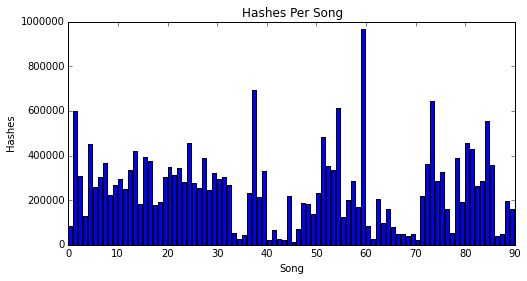

In [101]:
plt.bar(np.arange(90),songHashCounts)
plt.title("Hashes Per Song")
plt.xlabel('Song')
plt.ylabel('Hashes')
plt.rcParams["figure.figsize"]= [4,8]
plt.show()

#### (c) Investigate common peaks 

In [88]:
sharedPeaks = hashes.map(lambda (hash,array): np.outer(array,array)).reduce(lambda x,y:x+y)

I normalized the shared hash counts by $\sqrt{h_1h_2}$, where $h_1$ and $h_2$ are the number of total hashes for each song. This has the properties that it is symmetric, scales a perfect match to 1, and will vaguely account for the difference in total hashes. The downside is that if we have a song matched with just the first half of the song, it will give a value less than 1, even though 100% of the potential matches are made.

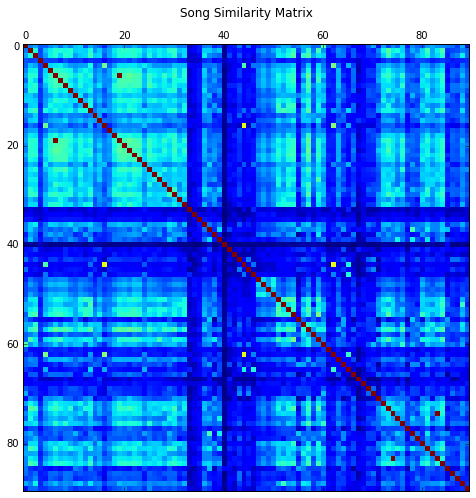

In [71]:
# Plot similarity matrix
similarityMat =(sharedPeaks/np.sqrt(np.outer(songHashCounts,songHashCounts)))
plt.matshow(similarityMat)
plt.title('Song Similarity Matrix')
plt.rcParams["figure.figsize"]= [8,8]
plt.show()

In [136]:
print "Perfect matches are:"
print [(x,y) for (x,y) in np.argwhere(similarityMat==1).tolist() if (x!=y and int(x)<=int(y))]
print "Imperfect matches over .6 are:"
print [(x,y) for (x,y) in np.argwhere(np.logical_and(similarityMat>.6,similarityMat<1)).tolist() if (x!=y and int(x)<=int(y))]

Perfect matches are:
[(6, 19), (74, 83)]
Imperfect matches over .6 are:
[(16, 44), (44, 62)]


We seem to have two pairs of songs which are perfect duplicates of each other; 6 and 19 are perfect matches, as are 74 and 83. They are marked by the red dots off diagonal, corresponding to scaled similarlity values of 1. The next closest pairs are 16 & 44 and 44 & 62, though they have similarity values just a bit over $.6$.